In [ ]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from typing import List, Dict, Any
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
# import time

# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.metrics import mean_squared_error
# from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import AutoEncoders as AE

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
#Recuerden cambiar las rutas a la que lleve a sus datos limpios
df = pd.read_pickle(r'Tesis\data\datos preprocesados\data_R5_lista.pkl')
df_eval = pd.read_pickle(r'Tesis\data\datos preprocesados\data_R6_lista.pkl')


In [5]:
booster = [
    # Parámetros
        "TempRodamientoLadoCargaMotorBbaBooster",
        "TempRodamientoLadoLibreMotorBbaBooster",
        "TempCojineteEmpujeBbaBooster",
        "VibracionCojineteEmpujeBbaBooster",
        "VibracionCojiRadialBbaBooster",
    # Operación
        "PresionEntredaBbaBooster",
        "VelocidadEjeBbaBooster",
        "CaudalAlimERS",
        "TempSalFiltroCartucho"
    ]

mainpump = [
    #Parámetros
        "VibracionBbaLadoCargaX",
        "VibracionBbaLadoCargaY",
        "VibracionBbaLadoLibreX",
        "VibracionBbaLadoLibreY",
        "VibracionBbaAxial",
        "TemperaturaCojineteBbaLadoCarga",
        "TemperaturaCojineteBbaLadoLibre",
        "TemperaturaCojineteMotorLadoCarga",
        "TemperaturaCojineteMotorLadoLibre",
        "TemperaturaBbaLubricacion",
        "TemperaturaDevenadoU1",
        "TemperaturaDevenadoV1",
        "TemperaturaDevenadoW1",
        #Operación
        "VelocidadEjeBbaPrincipal",
        "PresionAlim",
        "TempSalFiltroCartucho"
]

In [6]:
# Filtrar para utilizar sólo los sensores relacionados a la minbomb
df = df[booster]
df_eval = df_eval[booster]
df_eval.isna().sum()

TempRodamientoLadoCargaMotorBbaBooster    0
TempRodamientoLadoLibreMotorBbaBooster    0
TempCojineteEmpujeBbaBooster              0
VibracionCojineteEmpujeBbaBooster         0
VibracionCojiRadialBbaBooster             0
PresionEntredaBbaBooster                  0
VelocidadEjeBbaBooster                    0
CaudalAlimERS                             0
TempSalFiltroCartucho                     0
dtype: int64

filtrar fechas que se utilizarán

In [7]:
#2022-10-29 00:00:00', '2022-12-22 12:39:00'

train = df['2023-01-15 00:00:00': '2023-03-10 00:00:00']
test = df['2023-03-10 00:00:00':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (147257, 9)
Test dataset shape: (1002413, 9)


Normalizar los datos, considerando los valores de entrenamiento

In [8]:
# Normalización de los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)

X_test = scaler.transform(test)
X_eval = scaler.transform(df_eval)


scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

Convertir los datos en secuencia para luego creear las ventanas

In [9]:
train_sequence  = X_train.astype(np.float32).tolist()
test_sequence = X_test.astype(np.float32).tolist()
eval_sequence = X_eval.astype(np.float32).tolist()


In [10]:
def sliding_window(data, seq_len=60, overlap=12):
    sequences = []
    for i in range(0, len(data) - seq_len + 1, seq_len - overlap):
        sequences.append(data[i:i+seq_len])
    return torch.tensor(sequences)

    

Train = sliding_window(train_sequence, seq_len=30, overlap=6)
Test = sliding_window(test_sequence, seq_len=30, overlap=6)

Eval = sliding_window(eval_sequence, seq_len=30, overlap=6)
print("Train shape: ", Train.shape)
print("Eval shape: ", Eval.shape)
print("Test shape: ", Test.shape)


Train shape:  torch.Size([6135, 30, 9])
Eval shape:  torch.Size([23289, 30, 9])
Test shape:  torch.Size([41766, 30, 9])


In [11]:
def reconstruct_from_sliding_window(tensor_data, seq_len=10, overlap=2):
    # Convertir el tensor a una lista de listas
    window_list = tensor_data.tolist()
    
    # Inicializar una lista para los datos reconstruidos
    reconstructed = []
    
    # Tamaño del paso (cantidad de datos no solapados)
    step_size = seq_len - overlap
    
    for i, window in enumerate(window_list):
        if i == len(window_list):
            # Agregar la primera ventana completa
            reconstructed.extend(window)
        else:
            # Agregar solo la parte no solapada de la ventana actual
            reconstructed.extend(window[:step_size])
    
    return reconstructed

In [ ]:
param_grid = {
    'h_layer_sizes': [
        [40, 24], [40, 20], [32, 20], [32, 24], [32, 16], [64, 24]],
    'learning_rate': [0.001, 0.0007],# 0.0001],
    'dropout': [0.1, 0]
}

autoencoder_wrapper = AE.AutoEncoderWrapper(
    h_layer_sizes=[64],
    timesteps=30,
    learning_rate=0.001,
    dropout=0,
    n_features_in=9,
    batch_size=8,
    optim='RAdam',
    epochs=300,
    verbose=0,
    patience=15
)

halving_grid = HalvingGridSearchCV(estimator=autoencoder_wrapper, param_grid=param_grid, cv=3, factor=2, resource='n_samples', max_resources='auto', verbose=1)
halving_grid_result = halving_grid.fit(Train)

print("Best: %f using %s" % (halving_grid_result.best_score_, halving_grid_result.best_params_))

Guardar los pesos del mejor modelo encontrado

In [ ]:
# Guardar los pesos del mejor modelo encontrado

best_model = halving_grid_result.best_estimator_
best_model.save_weights('best_model.pth')


Nunca está de más liberar la memoria de cuda una vez guardados los pesos

In [ ]:
torch.cuda.empty_cache()  # Liberar caché de GPU

A continuación repetiré el entrenamiento ganador para obtener los gráficos asociados

In [ ]:
best_autoencoder = AE.AutoEncoder(
    h_layer_sizes=[64, 24],
    timesteps=30,
    learning_rate=0.0007,
    dropout=0,
    n_features_in=9,
    batch_size=8,
    epochs=300,
    verbose=5,
    patience=20
)

Epoch 0/300, Loss validación: 0.012610746230083432, R^2 validación: -347.1583988635571, R^2 entrenamiento: -1630.5858608238939
Epoch 5/300, Loss validación: 0.012710571219515684, R^2 validación: -1062.8630953702059, R^2 entrenamiento: -1030.264032358363
Epoch 10/300, Loss validación: 0.005560135207284097, R^2 validación: -1173.572334487717, R^2 entrenamiento: -800.6677357383396
Epoch 15/300, Loss validación: 0.005596275477633848, R^2 validación: -1243.0717741730925, R^2 entrenamiento: -1267.3375492040661
Epoch 20/300, Loss validación: 0.005561762389593891, R^2 validación: -341.83019474574496, R^2 entrenamiento: -758.0268734779911
Epoch 25/300, Loss validación: 0.0038876494607440644, R^2 validación: -35.562737437037676, R^2 entrenamiento: -87.31846900297248
Epoch 30/300, Loss validación: 0.0035147055954817537, R^2 validación: -63.313278445949805, R^2 entrenamiento: -88.98124673262886
Epoch 35/300, Loss validación: 0.00209810691485, R^2 validación: -56.97091105077174, R^2 entrenamiento: 

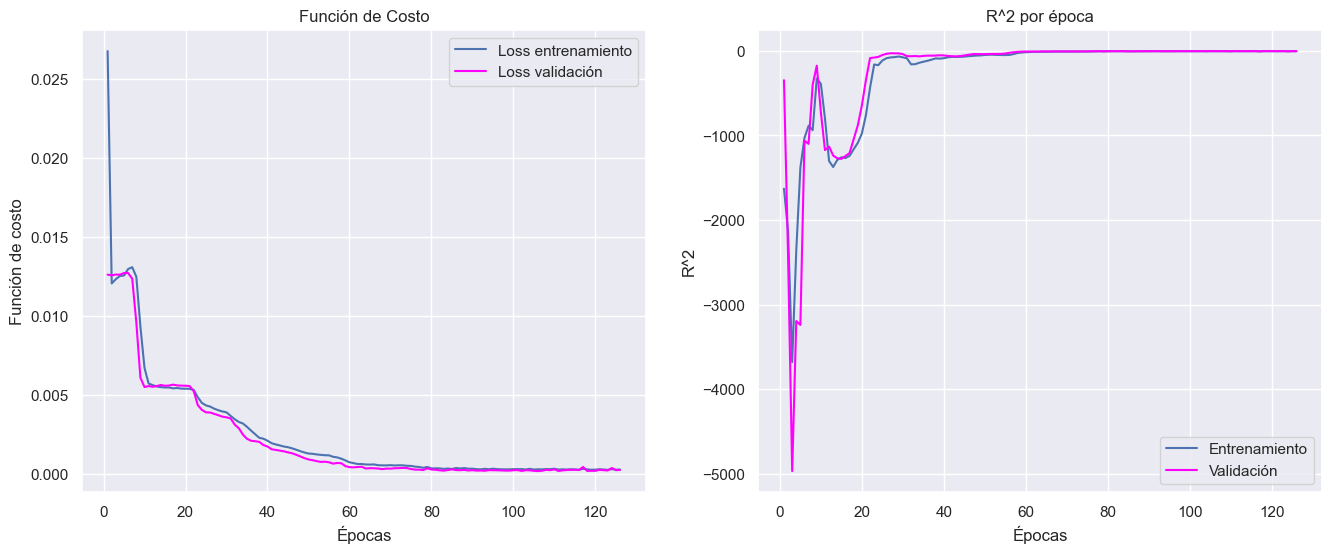

In [ ]:
best_autoencoder.fit(Train)
best_autoencoder.save_weights(filepath='best_CB.pth')

Así se utiliza un modelo guardado:

In [ ]:
#AQUI ES IMPORTANTE QUE SEA LA ARUITECTURA DEL MEJOR MODELO para que pueda cargar
best_autoencoder = AE.AutoEncoder(
    h_layer_sizes=[64, 24],
    timesteps=30,
    learning_rate=0.0007,
    dropout=0,
    n_features_in=9,
    batch_size=8,
    epochs=300,
    verbose=5,
    patience=20
)

# Inicializar el modelo y cargar los pesos guardados
best_autoencoder.model_ = best_autoencoder.build_model()
best_autoencoder.model_.load_state_dict(torch.load(r'modelos\best_CB.pth'))

# Mover el modelo a la GPU si está disponible
best_autoencoder.model_.to(best_autoencoder.device)


Autoencoder(
  (encoder): Encoder(
    (model): ModuleList(
      (0): LSTM(9, 64, batch_first=True)
      (1): Dropout(p=0, inplace=False)
      (2): LSTM(64, 24, batch_first=True)
      (3): Dropout(p=0, inplace=False)
    )
  )
  (decoder): Decoder(
    (model): ModuleList(
      (0): LSTM(24, 24, batch_first=True)
      (1): Dropout(p=0, inplace=False)
      (2): LSTM(24, 64, batch_first=True)
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=64, out_features=9, bias=True)
    )
  )
)